In [3]:
import numpy as np
import torch
import gpytorch
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
from torch.autograd import Variable
# Training data is 11 points in [0,1] inclusive regularly spaced
train_x = Variable(torch.linspace(0, 1, 11))
# True function is sin(2*pi*x) with Gaussian noise N(0,0.04)
train_y = Variable(torch.sin(train_x.data * (2 * np.pi)) + torch.randn(train_x.size()) * 0.2)

In [5]:
from torch import optim
from gpytorch.kernels import RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

In [44]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, W):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        # Our mean function is constant in the interval [-1,1]
        self.mean_module = ConstantMean(constant_bounds=(-1, 1))
        # We use the RBF kernel as a universal approximator
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-10, 10))
        
        self.W = torch.from_numpy(W).float()
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
#         print(covar_x.type())
#         print(self.W.type())
        covar_x = self.W.t().matmul(covar_x.matmul(self.W))
        # Return moddl output as GaussianRandomVariable
        return GaussianRandomVariable(mean_x, covar_x)

# initialize likelihood and model
likelihood = GaussianLikelihood(log_noise_bounds=(-5, 5))
# W = 1*np.ones((train_x.data.shape[0], train_x.data.shape[0]), dtype=np.float)
W = np.random.randn(train_x.data.shape[0], train_x.data.shape[0])
W = np.matmul(W.T,W)

model = ExactGPModel(train_x.data, train_y.data, likelihood, W)
model.covar_module.

<bound method Module.parameters of RBFKernel()>

In [42]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 100
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   log_lengthscale: %.3f   log_noise: %.3f' % (
        i + 1, training_iter, loss.data[0],
        model.covar_module.log_lengthscale.data[0, 0],
        model.likelihood.log_noise.data[0]
    ))
    optimizer.step()

/home/lerko/anaconda3/lib/python3.6/site-packages/gpytorch/functions/add_diag.py:14: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  val = diag.squeeze()[0]


Iter 1/100 - Loss: 1.579   log_lengthscale: 0.000   log_noise: 0.000
Iter 2/100 - Loss: 1.581   log_lengthscale: -0.100   log_noise: -0.100
Iter 3/100 - Loss: 1.569   log_lengthscale: -0.200   log_noise: -0.200
Iter 4/100 - Loss: 1.583   log_lengthscale: -0.183   log_noise: -0.300
Iter 5/100 - Loss: 1.582   log_lengthscale: -0.156   log_noise: -0.399
Iter 6/100 - Loss: 1.598   log_lengthscale: -0.107   log_noise: -0.498
Iter 7/100 - Loss: 1.450   log_lengthscale: -0.077   log_noise: -0.596
Iter 8/100 - Loss: 1.548   log_lengthscale: -0.068   log_noise: -0.694
Iter 9/100 - Loss: 1.605   log_lengthscale: -0.046   log_noise: -0.792
Iter 10/100 - Loss: 1.658   log_lengthscale: -0.050   log_noise: -0.887
Iter 11/100 - Loss: 1.685   log_lengthscale: -0.049   log_noise: -0.980
Iter 12/100 - Loss: 1.408   log_lengthscale: -0.074   log_noise: -1.071
Iter 13/100 - Loss: 1.639   log_lengthscale: -0.096   log_noise: -1.161
Iter 14/100 - Loss: 1.639   log_lengthscale: -0.111   log_noise: -1.248
Ite

In [43]:
np.exp(-0.201)

0.8179124315538594

RuntimeError: size mismatch, m1: [62 x 62], m2: [11 x 11] at /opt/conda/conda-bld/pytorch_1524584710464/work/aten/src/TH/generic/THTensorMath.c:2033

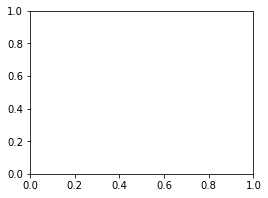

In [32]:
# Put model and likelihood into eval mode
model.eval()
likelihood.eval()

# Initialize plot
f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
# Test points are regularly spaced along [0,1] every 0.02
test_x = Variable(torch.linspace(0, 1, 51))
# Make predictions by feeding model through likelihood
with gpytorch.fast_pred_var():
    observed_pred = likelihood(model(test_x))

# Define plotting function
def ax_plot(ax, rand_var, title):
    # Get upper and lower confidence bounds
    lower, upper = rand_var.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.data.numpy(), rand_var.mean().data.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.data.numpy(), lower.data.numpy(), upper.data.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(title)
# Plot the predictions
ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')

In [7]:
torch.cuda.is_available()


True

In [9]:
torch.Tensor().cuda()

[torch.cuda.FloatTensor with no dimension]